<a href="https://colab.research.google.com/github/thoriq131/Animasi-Bunga/blob/main/Deep_Transfer_Learning_dan_Augmentasi_Gambar_Pada_Klasifikasi_Masker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Face Mask Detection**

Program Machine Learning untuk mendeteksi penggunaan masker. Program dibuat menggunakan metode CNN dengan arsitektur VGG16Net dan caffe model ResNet-10 untuk face detection.

In [ ]:
!nvidia-smi

Mon Jun 10 03:34:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Memeriksa CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


## Tahap Awal

In [ ]:
# Melakukan cloning data
!git clone https://github.com/Soedirman-Machine-Learning/face-mask-detection.git

Cloning into 'face-mask-detection'...
remote: Enumerating objects: 4737, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 4737 (delta 19), reused 35 (delta 19), pack-reused 4701
Receiving objects: 100% (4737/4737), 469.11 MiB | 34.23 MiB/s, done.
Resolving deltas: 100% (119/119), done.
Updating files: 100% (4424/4424), done.


In [ ]:
# Berpindah ke folder face-mask-detection
%cd face-mask-detection/

# Memeriksa isi folder face-mask-detection
!ls

/content/face-mask-detection
'aplikasi android'
 Aplikasi-Android.gif
'berkas tugas akhir'
 dataset
 face-detector.zip
 Face_Mask_Detection_MobileNetV2_with_MTCNN.ipynb
 Face_Mask_Detection_MobileNetV2_with_ResNet10.ipynb
 Face_Mask_Detection_VGG16Net_with_MTCNN.ipynb
 Face_Mask_Detection_VGG16Net_with_ResNet10.ipynb
 Full_Face_Mask_Detection_MobileNetV2.ipynb
 Full_Face_Mask_Detection_VGG16Net.ipynb
 logo-md1png.png
 mask_model.tflite
 pengujian
 README.md


**Face-detector.zip** merupakan file untuk melakukan pengujian model dengan menggunakan res10_300x300_ssd_iter_140000.caffemodel dan deploy.prototxt untuk mendeteksi bagian wajah

In [ ]:
# Melakukan unzip pada folder face-detector.zip
!unzip face-detector.zip

Archive:  face-detector.zip
  inflating: deploy.prototxt         
  inflating: example_img/ex01.jpg    
  inflating: example_img/ex02.jpg    
  inflating: example_img/ex03.jpg    
  inflating: example_img/ex04.jpg    
  inflating: example_img/ex05.jpg    
  inflating: example_img/ex06.jpg    
  inflating: example_img/ex07.jpg    
  inflating: example_img/ex08.jpg    
  inflating: example_img/ex09.jpg    
  inflating: example_img/ex10.jpg    
  inflating: res10_300x300_ssd_iter_140000.caffemodel  


## Mengimpor Libraries yang dibutuhkan

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import argparse
import os
import itertools

# Mengihitung waktu lamanya eksekusi tiap sel di Google Colab
!pip install ipython-autotime

%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.4 MB/s eta 0:00:00
time: 290 µs (started: 2024-06-10 03:35:59 +00:00)


In [ ]:
# Memeriksa Versi TensorFlow
print(tf.__version__)

2.15.0
time: 549 µs (started: 2024-06-10 03:36:13 +00:00)


## Preprocessing Datasets

In [ ]:
# Inisialisasi nilai Initial Learning Rate, berapa banyak Epoch pelatihan, dan Batch Size
INIT_LR = 1e-4
EPOCHS = 30
BS = 32

# Mengambil gambar dari dataset directory, kemudian inisialisasi data dan class gambar
print("Menginput gambar...")
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []

# Melakukan perulangan pada image paths
for imagePath in imagePaths:

    # Mengekstrak class label dari filename
    label = imagePath.split(os.path.sep)[-2]
    # Memuat input gambar (224x224) dan melakukan proses
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # Mengupdate data dan labels lists, berurutan
    data.append(image)
    labels.append(label)

# Mengkonversi data dan label ke dalam NumPy Arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Melakukan one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print("Input gambar berhasil")

Menginput gambar...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Input gambar berhasil
time: 13.9 s (started: 2024-06-10 03:36:23 +00:00)


### Membuat objek ImageDataGenerator dan Data Augmentation

In [ ]:
# Mempartisi data ke dalam pelatihan dan pengujian ( 75% : 25% )
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

# Membentuk training image generator untuk data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

time: 1.32 s (started: 2024-06-10 03:36:49 +00:00)


## Membuat Model Jaringan CNN yang sudah dipelajari sebelumnya (pre-trained convnets)

In [ ]:
# Arsitektur jaringan VGG16Net
baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

58889256/58889256 [==============================] - 0s 0us/step
time: 1.56 s (started: 2024-06-10 03:36:59 +00:00)


### Feature Extraction

In [ ]:
baseModel.trainable = False
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Tahap Pembuatan Model

In [ ]:
# Membentuk bagian head dari model yang akan ditempatkan pada base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Menempatkan head model pada base model
model = Model(inputs=baseModel.input, outputs=headModel)

# Perulangan pada seluruh base model
for layer in baseModel.layers:
    layer.trainable = False

# Persiapan kompilasi model
print("Mengkompilasi model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

model.summary()

Mengkompilasi model...


ValueError: decay is deprecated in the new Keras optimizer, please check the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.Adam.

time: 255 ms (started: 2024-06-10 03:37:18 +00:00)


### Melakukan Pelatihan Model

In [ ]:
# Pelatihan model
print("Training head model...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Training head model...


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

time: 24.5 ms (started: 2024-06-10 03:37:26 +00:00)


## Menampilkan Grafik Model Hasil Pelatihan

NameError: name 'H' is not defined

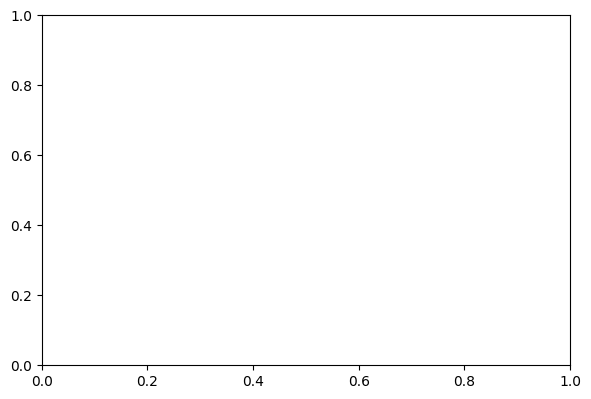

time: 317 ms (started: 2024-06-10 03:37:32 +00:00)


In [ ]:
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)

plt.subplot(2, 2, 1)
plt.plot(np.arange(0, N), H.history["accuracy"],label = "Training Accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Akurasi")
plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder = 0)

plt.subplot(2, 2, 2)
plt.plot(np.arange(0, N), H.history["loss"],label = "Training Loss")
plt.plot(np.arange(0, N), H.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Error")
plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder = 0)
plt.show()

## Evaluasi Jaringan

In [ ]:
# Memeriksa matriks model
print(model.metrics_names)
# Evaluasi data test
print(model.evaluate(x= testX, y = testY))

[]


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

time: 63.8 ms (started: 2024-06-10 03:37:52 +00:00)


In [ ]:
# Menampilkan matriks yang benar dan matriks hasil prediksi
# Label yang benar
yTrue = np.argmax(testY, axis=1)

# Label prediksi
YPred = model.predict(testX, batch_size=BS)
yPred = np.argmax(YPred, axis=1)

print(yTrue)
print(yPred)

24/24 [==============================] - 17s 384ms/step
[0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0
 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1
 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0
 0 0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1
 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0
 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1
 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0
 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0
 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1
 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1
 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1
 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0

## Confusion Matrix

In [ ]:
def get_confusion_matrix(yTrue, yPred):
    n_classes = len(np.unique(yTrue))
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(yTrue, yPred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

time: 809 µs (started: 2024-06-10 03:38:22 +00:00)


In [ ]:
conf = get_confusion_matrix(yTrue, yPred)
conf

array([[209, 174],
       [202, 182]])

time: 4.17 ms (started: 2024-06-10 03:38:26 +00:00)


Text(0.5, 23.52222222222222, 'Label Prediksi')

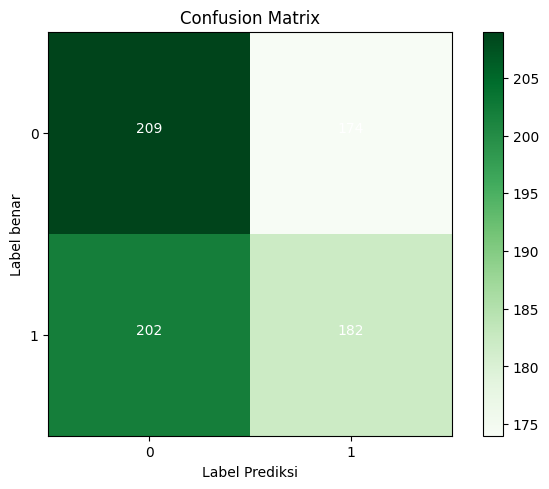

time: 269 ms (started: 2024-06-10 03:38:30 +00:00)


In [ ]:
classes = [0, 1]
# Plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Label benar')
plt.xlabel('Label Prediksi')

Analisis mAP

In [ ]:
# Berdasarkan confusion matrix
TP = true_pos = 378
TN = true_neg = 372
FP = false_pos = 11
FN = false_neg = 6

time: 601 µs (started: 2024-06-10 03:38:35 +00:00)


In [ ]:
results = {}

# Akurasi
metric = "Akurasi"
results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} = {results[metric]: .3f}")

# Recall
metric = "Recall"
results[metric] = TP / (TP + FN)
print(f"{metric} = {results[metric]: .3f}")

# Presisi
metric = "Presisi"
results[metric] = TP / (TP + FP)
print(f"{metric} = {results[metric]: .3f}")

# Nilai F1
metric = "F1"
results[metric] = 2 / (1 / results["Presisi"] + 1 / results["Recall"])
print(f"{metric} = {results[metric]: .3f}")

Akurasi =  0.978
Recall =  0.984
Presisi =  0.972
F1 =  0.978
time: 1.24 ms (started: 2024-06-10 03:38:41 +00:00)


In [ ]:
# Membuat prediksi dari pengujian
predIdxs = model.predict(testX, batch_size=BS)

# Untuk setiap gambar dalam set pengujian, kita perlu menemukan indeks label
# dengan probabilitas prediksi terbesar
predIdxs = np.argmax(predIdxs, axis=1)

# Menampilkan laporan klasifikasi yang diformat dengan baik
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

24/24 [==============================] - 3s 123ms/step
              precision    recall  f1-score   support

   with_mask       0.51      0.55      0.53       383
without_mask       0.51      0.47      0.49       384

    accuracy                           0.51       767
   macro avg       0.51      0.51      0.51       767
weighted avg       0.51      0.51      0.51       767

time: 3.41 s (started: 2024-06-10 03:38:45 +00:00)


## Menyimpan dan Konversi Model ke ".tflite"
Menyimpan model menggunakan tf.saved_model/save dan kemudian mengkonversi model tersimpan ke format yang kompatibel tf lite.

In [ ]:
export_dir='saved_model/1'
tf.saved_model.save(model, export_dir)

time: 1.94 s (started: 2024-06-10 03:39:10 +00:00)


In [ ]:
# Mengkonvert model ke format tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

time: 2.04 s (started: 2024-06-10 03:39:20 +00:00)


In [ ]:
# Menyimpan model
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

59131320

time: 56.8 ms (started: 2024-06-10 03:39:25 +00:00)


In [ ]:
# Memuat model dan mengalokasikan ke tensor
interpreter = tf.lite.Interpreter(model_content = tflite_model)
interpreter.allocate_tensors()

# Mendapatkan input dan ouput tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

print(input_details)
print(output_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 52, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
time: 88 ms (started: 2024-06-10 03:39:27 +00:00)


# Pengujian Model dengan SSD ResNet10

Model diujikan pada gambar dan secara real-time dengan menggunakan res10_300x300_ssd_iter_14000.caffemodel dan deploy.prototxt yang digunakan untuk mendeteksi wajah.

## Penggunaan Model pada Gambar


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

time: 8.29 ms (started: 2024-06-10 03:39:37 +00:00)


In [ ]:
image = cv2.imread('/content/face-mask-detection/example_img/ex3.jpg')
orig = image.copy()
(h, w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

net=cv2.dnn.readNet('/content/face-mask-detection/deploy.prototxt','/content/face-mask-detection/res10_300x300_ssd_iter_140000.caffemodel')

# Melewatkan blob melalui jaringan dan mendapatkan deteksi wajah
print("Mendeteksi wajah...")
net.setInput(blob)
detections = net.forward()

for i in range(0, detections.shape[2]):
	# ekstrak keyakinan (yaitu, probabilitas) yang terkait dengan deteksi
	confidence = detections[0, 0, i, 2]

	if confidence > 0.5:
		# Menghitung koordinat (x, y) dari kotak pembatas untuk objek
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# Memastikan kotak pembatas berada dalam dimensi bingkai
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
    # dan mengubah ukurannya menjadi 224x224, dan lalu pre-proses
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# Membaca wajah dengan model
		(mask, withoutMask) = model.predict(face)[0]

		# Menggunakan masker hijau, tidak bermasker merah
		label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
		color = (0, 255, 0) if label == "Bermasker" else (0, 0, 255)

		# Probabilitas hasil deteksi
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# Menampilkan hasil dengan label dan kotak
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_TRIPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# Menampilkan output
cv2_imshow(image)
cv2.waitKey(0)

AttributeError: 'NoneType' object has no attribute 'copy'

time: 32 ms (started: 2024-06-10 03:39:42 +00:00)


## Pengujian Deteksi Perframe Capture

In [ ]:
# Mengimport lib
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os

def detect_and_predict_mask(frame, faceNet, maskNet):
    # Membuat dimensi kotak deteksi
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
        (104.0, 177.0, 123.0))

    # Melewatkan blob dan mendeteksi wajah
    faceNet.setInput(blob)
    detections = faceNet.forward()

    # Inisialisasi
    faces = []
    locs = []
    preds = []

    for i in range(0, detections.shape[2]):
        # ekstrak keyakinan (yaitu, probabilitas) yang terkait dengan deteksi
        confidence = detections[0, 0, i, 2]

        if confidence > 0.5:
            # Menghitung koordinat (x, y) dari kotak pembatas untuk objek
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # Memastikan kotak pembatas berada dalam dimensi bingkai
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
            # dan mengubah ukurannya menjadi 224x224, dan lalu pre-proses
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            # Menambahkan kotak deteksi
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    return (locs, preds)

faceNet=cv2.dnn.readNet('/content/face-mask-detection/deploy.prototxt','/content/face-mask-detection/res10_300x300_ssd_iter_140000.caffemodel')

time: 54.6 ms (started: 2024-06-10 03:39:46 +00:00)


In [ ]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'Ketika selesai, klik disini atau pada video untuk berhenti dari demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

time: 1.35 ms (started: 2024-06-10 03:39:51 +00:00)


In [ ]:
def js_reply_to_image(js_reply):
    """
    input:
          js_reply: JavaScript object, contain image from webcam
    output:
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)

    return image_array

time: 715 µs (started: 2024-06-10 03:39:57 +00:00)


<IPython.core.display.Javascript object>

1/1 [==============================] - 2s 2s/step


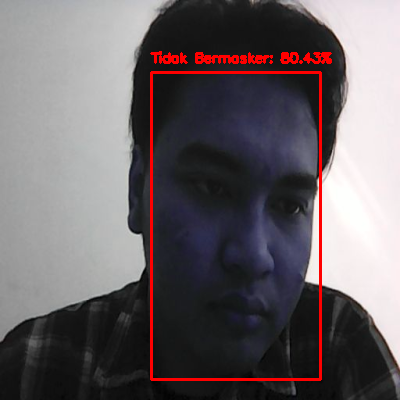

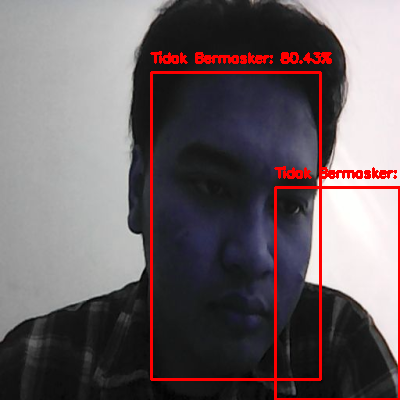

1/1 [==============================] - 1s 1s/step


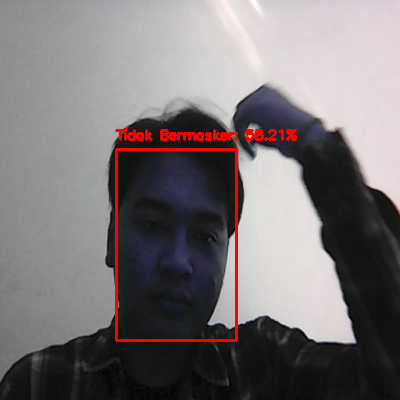

1/1 [==============================] - 0s 18ms/step


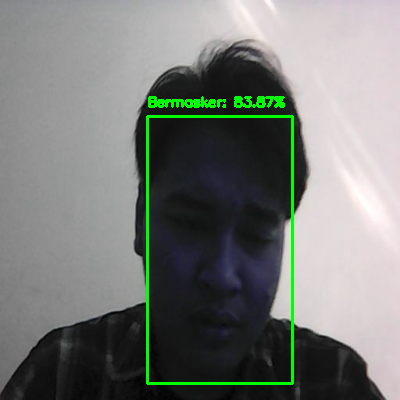

1/1 [==============================] - 0s 28ms/step


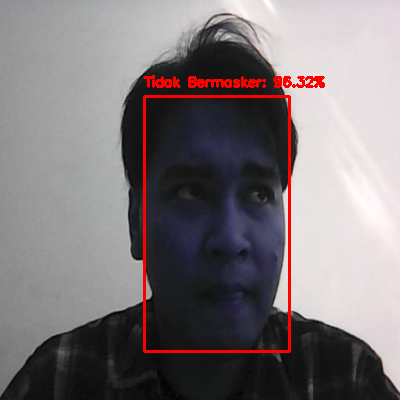

1/1 [==============================] - 0s 18ms/step


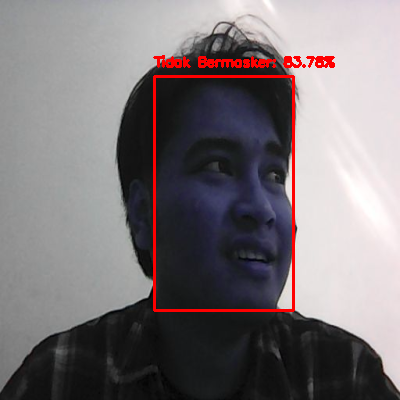

1/1 [==============================] - 0s 18ms/step


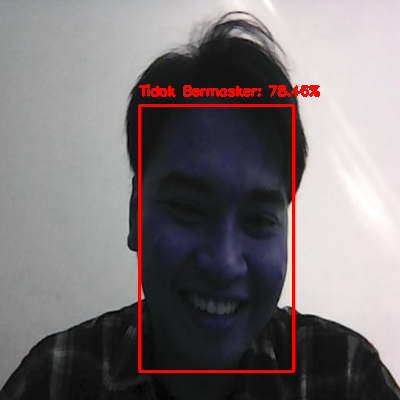

1/1 [==============================] - 0s 18ms/step


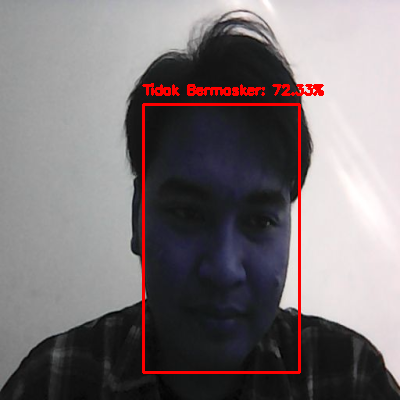

1/1 [==============================] - 0s 17ms/step


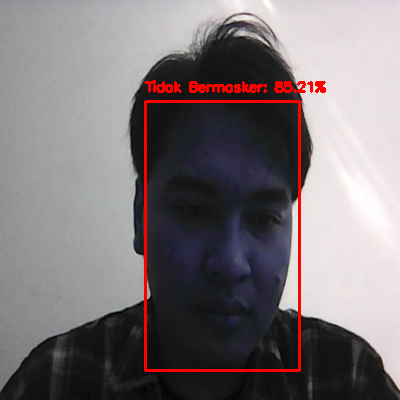

1/1 [==============================] - 0s 17ms/step


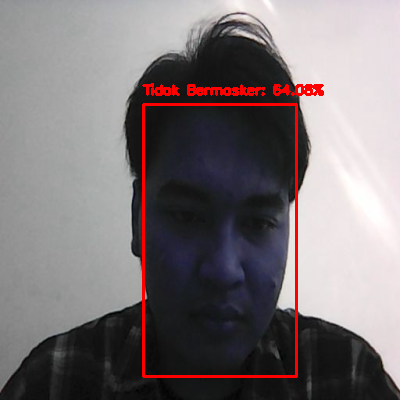

1/1 [==============================] - 0s 19ms/step


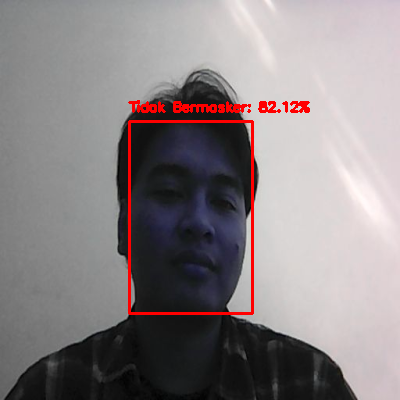

1/1 [==============================] - 0s 18ms/step


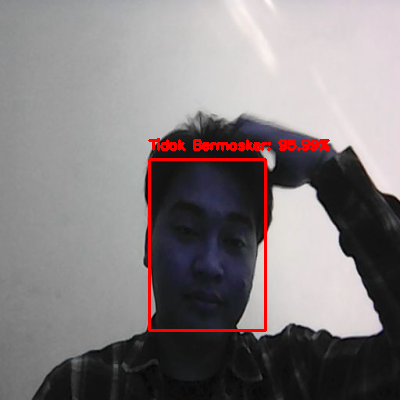

1/1 [==============================] - 0s 17ms/step


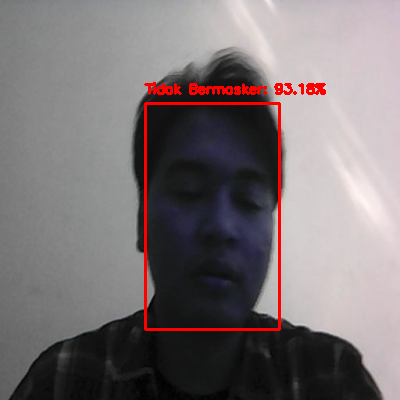

1/1 [==============================] - 0s 18ms/step


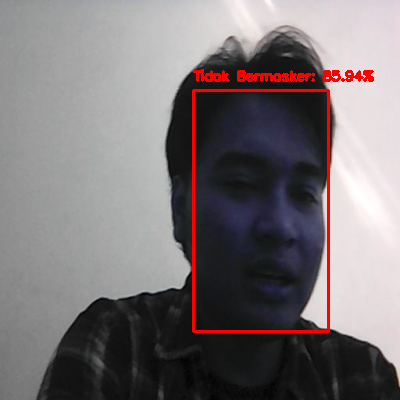

1/1 [==============================] - 0s 18ms/step


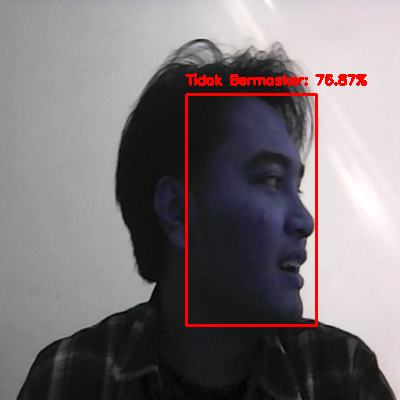

1/1 [==============================] - 0s 20ms/step


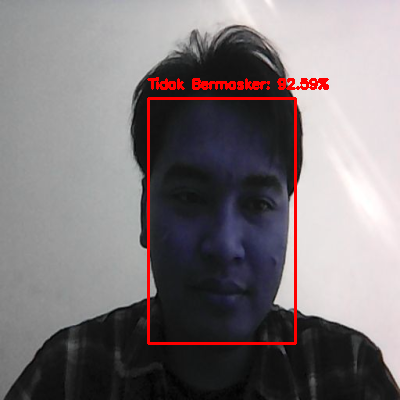

1/1 [==============================] - 0s 19ms/step


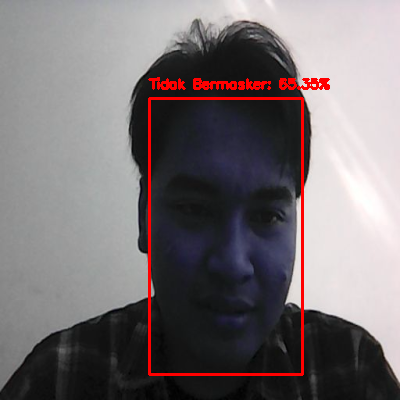

1/1 [==============================] - 0s 19ms/step


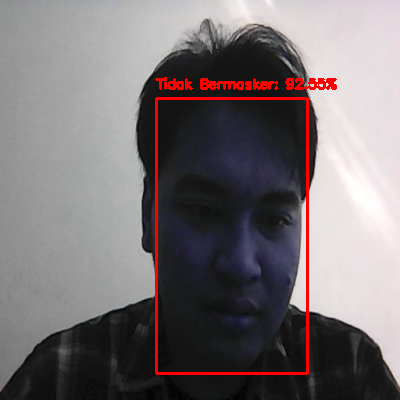

1/1 [==============================] - 0s 27ms/step


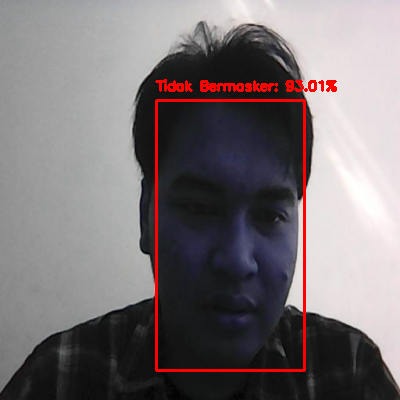

1/1 [==============================] - 0s 31ms/step


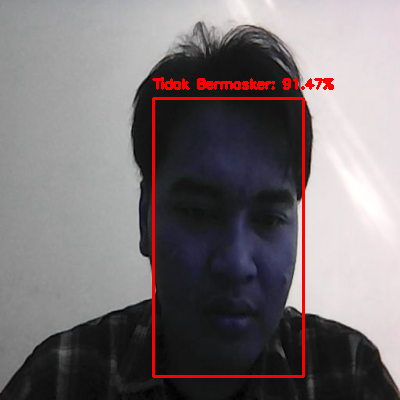

1/1 [==============================] - 0s 18ms/step


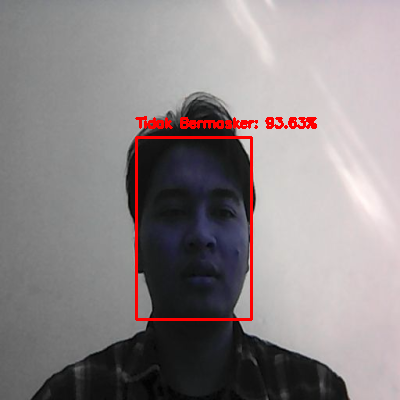

1/1 [==============================] - 0s 18ms/step


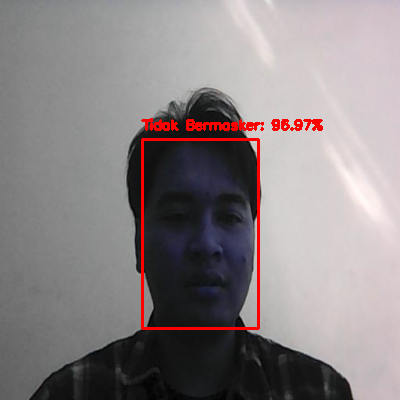

1/1 [==============================] - 0s 20ms/step


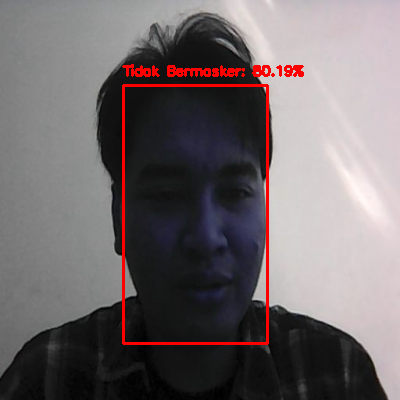

1/1 [==============================] - 0s 18ms/step


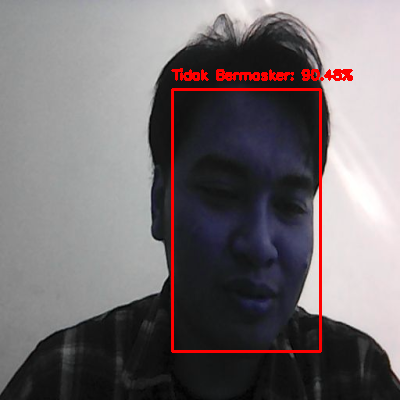

1/1 [==============================] - 0s 19ms/step


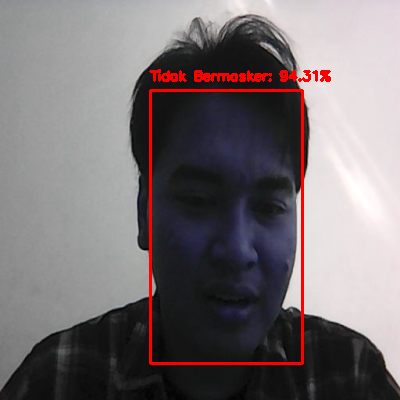

1/1 [==============================] - 0s 19ms/step


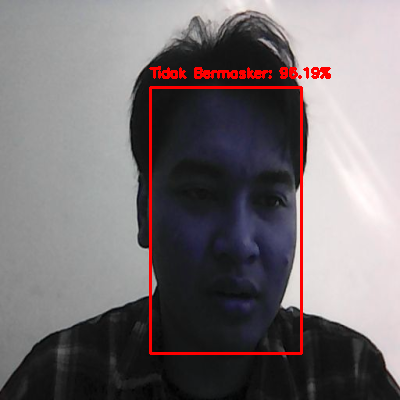

KeyboardInterrupt: 

time: 1min 9s (started: 2024-06-10 03:40:01 +00:00)


In [ ]:
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0
from google.colab.patches import cv2_imshow
while True:
  js_reply = take_photo(label_html, img_data)
  if not js_reply:
    break

  image = js_reply_to_image(js_reply)

	# Mengambil frame dari aliran video berulir dan
  # ukurannya maksimum lebar 400 pixel
  frame = image
  v=True
  if v == True:

    frame = imutils.resize(frame, width=400)

	# Mendeteksi bermasker atau tidak
    (locs, preds) = detect_and_predict_mask(frame, faceNet, model)
    for (box, pred) in zip(locs, preds):


		# Membuka kotak dan prediksi
      (startX, startY, endX, endY) = box
      (mask, withoutMask) = pred

		# Menggunakan masker hijau, tidak bermasker merah
      label = "Tidak Bermasker" if mask > withoutMask else "Bermasker"
      color = (0, 255, 0) if label == "Bermasker" else (0, 0, 255)

		# Probabilitas pada label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# Menampilkan hasil dengan label dan kotak dari frame
      frame=cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      frame=cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# Menampilkan ouput
      cv2_imshow(frame)

## Pengujian Streaming Video

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

time: 923 µs (started: 2024-06-10 03:41:20 +00:00)


In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

time: 734 µs (started: 2024-06-10 02:36:49 +00:00)


In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

time: 567 µs (started: 2024-06-10 02:36:54 +00:00)


In [ ]:
 def detect_and_predict_mask(img, faceNet, maskNet):
    # Membuat dimensi kotak deteksi
    (h, w) = img.shape[:2]
    blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300),
        (104.0, 177.0, 123.0))

    # Melewatkan blob dan mendeteksi wajah
    faceNet.setInput(blob)
    detections = faceNet.forward()

    # Inisialisasi
    faces = []
    locs = []
    preds = []

    for i in range(0, detections.shape[2]):
        # ekstrak keyakinan (yaitu, probabilitas) yang terkait dengan deteksi
        confidence = detections[0, 0, i, 2]

        if confidence > 0.5:
            # Menghitung koordinat (x, y) dari kotak pembatas untuk objek
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # Memastikan kotak pembatas berada dalam dimensi bingkai
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
            # dan mengubah ukurannya menjadi 224x224, dan lalu pre-proses
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            # Menambahkan kotak deteksi
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    return (locs, preds)

faceNet=cv2.dnn.readNet('/content/face-mask-detection/deploy.prototxt','/content/face-mask-detection/res10_300x300_ssd_iter_140000.caffemodel')

time: 14.1 ms (started: 2024-06-10 02:37:01 +00:00)


In [ ]:
# Memulai streaming video dari webcam
video_stream()
# Label untuk video
label_html = 'Capturing...'
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Mengkonvert JS response ke OpenCV Image
    img = js_to_image(js_reply["img"])

    # Membuat transparan overlay untuk bounding box
    bbox_array = np.zeros([512,512,4], dtype=np.uint8)

    # Mendeteksi bermasker atau tidak
    (locs, preds) = detect_and_predict_mask(img, faceNet, model)
    for (box, pred) in zip(locs, preds):

		# Membuka kotak dan prediksi
      (startX, startY, endX, endY) = box
      (mask, withoutMask) = pred

		# Menggunakan masker hijau, tidak bermasker merah
      label = "Bermasker" if mask > withoutMask else "tidak Bermasker"
      color = (0, 255, 0) if label == "Bermasker" else (255, 0, 0)

		# Probabilitas pada label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# Menampilkan hasil dengan label dan kotak dari frame
      bbox_array=cv2.putText(bbox_array, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      bbox_array=cv2.rectangle(bbox_array, (startX, startY), (endX, endY), color, 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

    # Mengkonversi overlay bbox ke dalam bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    # Mengupdate bbox ke pada frame selanjutnya untuk mendapat overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 18ms/step


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


time: 40.6 s (started: 2024-06-10 02:45:01 +00:00)
